# Knowledge Distillation with Vision Tranformers

In this project, Knowledge Distillation techniques to the [oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset, a datset with *37 classes of dogs and cats*.

---

## Install Dependencies

In [ ]:
!pip install datasets transformers evaluate pytorch-lightning tensorboard --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Import Dependencies

In [ ]:
from datasets import load_dataset, DatasetDict, Features, Image as DatasetsImage, ClassLabel, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTConfig, ViTForImageClassification
from transformers import ViTImageProcessor, ViTConfig, ViTForImageClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import io

## Dataset

In [ ]:
dataset = load_dataset("pcuenq/oxford-pets")

README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

(…)-00000-of-00001-ecc2afb43dedd5e0.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

In [ ]:
# Interconversion of class ID and class name
id2label = {int_label: str_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}
label2id = {str_label: int_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}

## Teacher Model

We will be distilling the knowledge from ```asusevski/vit-base-patch16-224-oxford-pets```, a fine-tuned model based on ```google/vit-base-patch16-224``` into a randomized ```WinKawaks/vit-tiny-patch16-224``` model. Note that the fine-tuned ViT model that will be our teacher model was trained on this dataset already, achieving about **93%** accuracy!

First, lets see the teacher in action:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model_name = "asusevski/vit-base-patch16-224-oxford-pets"
teacher_model = AutoModelForImageClassification.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
accuracy = evaluate.load("accuracy")

config.json:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

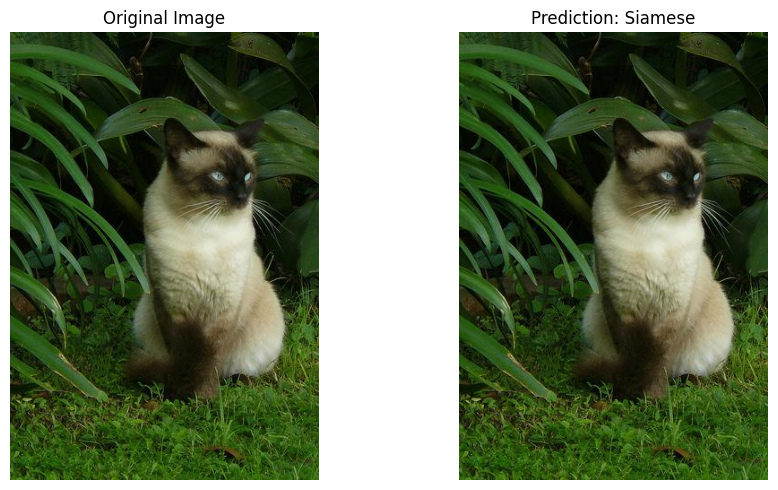

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

# Decode the image bytes
image_bytes = dataset["train"][0]["image"]["bytes"]
image = Image.open(io.BytesIO(image_bytes))  # Convert bytes to a PIL image

# Process the image
inputs = processor(image, return_tensors="pt")
inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to the device

# Perform inference with the teacher model
model_logits = teacher_model(**inputs).logits
model_prediction = torch.argmax(model_logits, dim=1).item()

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Plot the image with the prediction
axes[1].imshow(image)
axes[1].axis('off')
axes[1].set_title(f"Prediction: {id2label[model_prediction]}")

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Print Teacher model parameters
total_params = sum(p.numel() for p in teacher_model.parameters())
print(f"Total Teacher Parameters: {total_params:,}")
print("-" * 50)

print("Teacher Model Summary:")
print(teacher_model)

Total Teacher Parameters: 85,827,109
--------------------------------------------------
Teacher Model Summary:
ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplac

---

## Vanilla ViT Model

Here, training metrics of the ViT model is evaluated.  
This is without Knowledge Distillation.

In [ ]:
# Dataset class for preprocessing
class OxfordPetsDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Access the image and label directly
        entry = self.data[idx]
        image_data = entry['image']['bytes']  # Extract image bytes
        label = entry['label']  # Integer label

        # Convert bytes to a PIL Image
        image = Image.open(io.BytesIO(image_data)).convert("RGB")

        # Apply the transformations
        image = self.transform(image)

        return image, label


class OxfordPetsDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

    def setup(self, stage=None):
        # Load dataset
        dataset = load_dataset("pcuenq/oxford-pets")

        # Create label mappings
        unique_labels = list(set(example["label"] for example in dataset["train"]))
        self.label_to_id = {label: idx for idx, label in enumerate(sorted(unique_labels))}

        # Encode labels
        dataset = dataset.map(lambda x: {"label": self.label_to_id[x["label"]]})

        # Split dataset
        split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
        self.train_data = split_dataset["train"]
        self.val_data = split_dataset["test"]

    def train_dataloader(self):
        train_dataset = OxfordPetsDataset(self.train_data, self.transform)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        val_dataset = OxfordPetsDataset(self.val_data, self.transform)
        return DataLoader(val_dataset, batch_size=self.batch_size)

In [ ]:
from transformer import PatchEmbedding, EncoderLayer

class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=6, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=6, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[EncoderLayer(n_heads=1, inner_transformer_size=768, inner_ff_size=3072, seq_len=1, dropout=0.1) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x


class LitViT(pl.LightningModule):
    def __init__(self, num_classes=37, learning_rate=1e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.vit = ViT(img_size=224, num_classes=num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.vit(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
# Replace the training loop with Lightning training
def train_model():
    # Initialize data module
    data_module = OxfordPetsDataModule(batch_size=32)

    # Initialize model
    model = LitViT(num_classes=37)

    # Configure trainer
    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',  # Automatically detect GPU/CPU
        devices=1,
        logger=TensorBoardLogger('lightning_logs/', name='vit'),
        callbacks=[
            ModelCheckpoint(
                dirpath='checkpoints',
                filename='vit-{epoch:02d}-{val_loss:.2f}',
                monitor='val_loss',
                mode='min'
            )
        ]
    )

    # Train the model
    trainer.fit(model, data_module)

    # Evaluate
    trainer.validate(model, data_module)

train_model()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | vit       | ViT              | 43.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
43.3 M    Trainable params
0         Non-trainable params
43.3 M    Total params
173.144   Total estimated model params size (MB)
118       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.09878213703632355    │
│         val_loss          │    3.2708890438079834     │
└───────────────────────────┴───────────────────────────┘

---
**KL Divergence** is a measure of how similar/dissimilar two probability distributions are. It quantifies how much information is lost when one distribution (our student) is used to approximate the other. If it is 0, then in the case of knowledge distillation, that would mean the student has nothing left to learn from the teacher.

Finally, we have the ```lambda parameter```.

**Lambda parameter** is a weight applied to the overall loss functions terms. There are two terms -- the distillation loss (which comes from the KL-Divergence, as discussed above), and the students' own loss on the dataset. We take a linear combination of these terms, weighted by lambda, and that is our overall loss.

Now we have to prepare the data for ingestion by the HuggingFace Trainer. We prepared the inputs by using the ```ViTImageProcessor``` class above, but we also need to preprare the labels for training. These transforms will be written in the function ```transforms``` and we will map the transforms to each observation in the dataset.

---

## Knowledge Distillation ViT Model

In [ ]:
import torch
import torch.nn.functional as F
# from final import OxfordPetsDataModule, LitViT
import pytorch_lightning as pl
from transformers import AutoModelForImageClassification, ViTImageProcessor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

class DistillationModel(pl.LightningModule):
    def __init__(self, num_classes=37, learning_rate=1e-4, alpha=0.5, temperature=3.0):
        super().__init__()
        # Student model
        self.student = LitViT(num_classes=num_classes)

        # Teacher model
        teacher_model_name = "asusevski/vit-base-patch16-224-oxford-pets"
        self.teacher = AutoModelForImageClassification.from_pretrained(teacher_model_name)
        self.teacher.eval()  # Set teacher to evaluation mode

        # Freeze teacher parameters
        for param in self.teacher.parameters():
            param.requires_grad = False

        # # Standard ViT preprocessing parameters
        # self.mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
        # self.std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)

        self.learning_rate = learning_rate
        self.alpha = alpha
        self.temperature = temperature

    def forward(self, x):
        return self.student(x)

    def _preprocess_images_for_teacher(self, images):
        # Normalize to [0, 1] range
        images = (images + 1) / 2.0
        # Apply ImageNet normalization
        images = (images - self.mean.to(images.device)) / self.std.to(images.device)
        return images

    def training_step(self, batch, batch_idx):
        images, labels = batch

        # Preprocess images for teacher
        # processed_images = self._preprocess_images_for_teacher(images)

        # Get teacher predictions
        with torch.no_grad():
            teacher_logits = self.teacher(images).logits

        # Get student predictions
        student_logits = self.student(images)

        # Calculate soft targets (distillation loss)
        soft_targets = F.softmax(teacher_logits / self.temperature, dim=1)
        student_logits_temp = student_logits / self.temperature
        distillation_loss = F.kl_div(
            F.log_softmax(student_logits_temp, dim=1),
            soft_targets,
            reduction='batchmean'
        ) * (self.temperature ** 2)

        # Calculate hard targets (standard cross-entropy loss)
        hard_loss = F.cross_entropy(student_logits, labels)

        # Combine losses
        loss = (self.alpha * distillation_loss) + ((1 - self.alpha) * hard_loss)

        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('distillation_loss', distillation_loss, prog_bar=True)
        self.log('hard_loss', hard_loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self.student(images)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

def train_with_distillation():
    # Initialize data module
    data_module = OxfordPetsDataModule(batch_size=32)

    # Initialize distillation model
    model = DistillationModel(
        num_classes=37,
        learning_rate=1e-4,  # Lower learning rate
        alpha=0.7,  # More weight to soft targets
        temperature=2.0  # Lower temperature for clearer signal
    )

    # Configure trainer
    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        devices=1,
        logger=TensorBoardLogger('lightning_logs/', name='distillation'),
        callbacks=[
            ModelCheckpoint(
                dirpath='distillation_checkpoints',
                filename='distill-{epoch:02d}-{val_loss:.2f}',
                monitor='val_loss',
                mode='min'
            )
        ],
        gradient_clip_val=1.0,
    )

    # Train the model
    trainer.fit(model, data_module)

    # Evaluate
    trainer.validate(model, data_module)

if __name__ == "__main__":
    train_with_distillation()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params | Mode 
--------------------------------------------------------------
0 | student | LitViT                    | 43.3 M | train
1 | teacher | ViTForImageClassification | 85.8 M | eval 
--------------------------------------------------------------
43.3 M    Trainable params
85.8 M    Non-trainable params
129 M     Total params
516.453   Total estimated model params size (MB)
119       Modules in train mode
226       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10487144440412521    │
│         val_loss          │    3.3618812561035156     │
└───────────────────────────┴───────────────────────────┘

---

## Results

| Model | Total Parameters | Validation Accuracy |
|-------|------------------|----------|
| Teacher|85,827,109       |  -        |
|ViT without KD|  43,300,000         |   9.87%       |
| ViT with KD |  43,300,000          |   10.48%       |


  
This shows KD in action to train a smaller model quickly

---

## Reference:
https://colab.research.google.com/github/johko/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/KnowledgeDistillation.ipynb#scrollTo=0bff3857-756f-4d0e-8fc8-33e3c2ae9f84